In [ ]:
# Connect to drive map to access documents
# from google.colab import drive
# drive.mount('/content/drive')

This section extracts tweets from Twitter using the Twitter API

In [ ]:
# Install tweepy
pip install tweepy

In [2]:
import tweepy as twitter
import json
import pandas as pd

The code below shows how we have extracted the tweets using the APIs. The APIs have been removed due to the security reasons mentioned in the report. The dataframe contatining the data is saved to the picle file, which can be loaded below. Please make sure to specify the right directory.

In [3]:

# Define Twitter API keys and tokens (keys removed due to security reasons)
# consumer_key = ''
# consumer_secret = ''
# token = ''
# token_secret = ''

In [4]:
# Authenticate to Twitter passing key and secret tokens
# auth = twitter.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(token, token_secret)

# Create API object - Wait on rate limit is true so that we can download the tweets
#without any connection break
# api = twitter.API(auth, wait_on_rate_limit=True)

In [ ]:
# Create dataframe to store API responses
# df = pd.DataFrame(columns=['tweets'])

# # Query hashtag
# hashtag = '#vaccinatiedwang'

# # Make request to the Twitter API and store respones (Tweets) in the dataframe
# tweets = twitter.Cursor(api.search, q=hashtag,lang='nl', result_type='recent', tweet_mode='extended').items()
# for tweet in tweets:
#     df = df.append({'tweets': tweet}, ignore_index=True)
# df

This section allows us to store the Twitter API responses and load them in again so that the API does not need to be re-queried when restarting the notebook

In [10]:
# Save and store Tweets from Twitter API
# df.to_pickle('all_tweets_from_past_week2.pkl')

In [3]:
# Read in the API responses from the stored dataframe (Change to the directory)
df = pd.read_pickle('/content/sample_data/all_tweets_from_past_week2.pkl')
df

,tweets
0,Status(_json={'created_at': 'Wed Dec 22 08:49:...
1,Status(_json={'created_at': 'Wed Dec 22 08:49:...
2,Status(_json={'created_at': 'Wed Dec 22 08:48:...
3,Status(_json={'created_at': 'Wed Dec 22 08:46:...
4,Status(_json={'created_at': 'Wed Dec 22 08:41:...
...,...
5230,Status(_json={'created_at': 'Mon Dec 13 08:17:...
5231,Status(_json={'created_at': 'Mon Dec 13 08:15:...
5232,Status(_json={'created_at': 'Mon Dec 13 08:15:...
5233,Status(_json={'created_at': 'Mon Dec 13 08:13:...


This section dives into extracting meaning from the Twitter API responses and giving shape to the data and information we need for the analysis

In [4]:
# Create dataframe in which the information will be stored
df_enriched = pd.DataFrame(columns=['Tweeter', 'Mentions', 'Hashtags', 'full_text', 'created_at'])

# For each tweet from all tweets (responses from the Twitter API)
for tweet in df.tweets:

  # Original creator of the tweet
    tweet_user = tweet.user._json['screen_name']

  # All mentions and hashtags per tweet will be stored in sets to avoid duplicates
    user_ment = set()
    hasht = set()

  # Get all users mentioned in the first 140 characters of the tweet and add to usermention set
    for i in tweet.entities.get('user_mentions'):
        user_ment.add(i['screen_name'])

  # Get all hashtags mentioned in the first 140 characters of the tweet and add to hashtag set
    for i in tweet.entities.get('hashtags'):
        hasht.add(i['text'])

  # In case the tweet is a retweet and thus 250 characters instead of 140
  # Get the user mentions and hashtags from the tweet and add to the sets
    try:
        for i in tweet.retweeted_status.entities.get('user_mentions'):
            user_ment.add(i['screen_name'])

        for i in tweet.retweeted_status.entities.get('hashtags'):
            hasht.add(i['text'])

        alle_tekst = tweet.retweeted_status.full_text

  # In case the tweet is not a retweet but longer than 140 characters
  # Get the user mentions and hashtags from the tweet and add to the sets
    except AttributeError:
        for i in tweet.entities.get('user_mentions'):
            user_ment.add(i['screen_name'])

        for i in tweet.entities.get('hashtags'):
            hasht.add(i['text'])

    alle_tekst = tweet.full_text
  
  # Add data to the enriched dataframe
    data = {'Tweeter':tweet_user, 'Mentions':list(user_ment), 'Hashtags':list(hasht), 'full_text':alle_tekst, 'created_at':tweet.created_at}
    df_enriched = df_enriched.append(data, ignore_index=True)

df_enriched

,Tweeter,Mentions,Hashtags,full_text,created_at
0,sineiraH,[attjekuiken],"[vaccinatiedwang, ggz, attje, idioten, pvda, c...",@attjekuiken Ik vind het bijvoorbeeld heel idi...,2021-12-22 08:49:37
1,clairedenbreeds,[Only125373831],"[vaccinatiedwang, VaccinatieSchade, gevaccinee...",Wat verdienen ziekenhuizen en doktoren in Nede...,2021-12-22 08:49:16
2,MartinMourik,[],"[vaccinatiedwang, Vaccinatie, vakantieprik, va...","Mooie hashtag, #vakantieprik. Kunnen we die tr...",2021-12-22 08:48:39
3,Kristof_A,[MiniToren],"[vaccinatiedwang, wakeup, QRcode, coronabeleid...",'We need to wake up.' Dr. Robert Malone legt p...,2021-12-22 08:46:55
4,mrselizabeth38,"[2_bloempje, RTLnieuws, NOS, telegraaf]","[2G, vaccinatiedwang, coronapaspoort, ditishet...",In München Duitsland 🇩🇪 was er gisteravond een...,2021-12-22 08:41:52
...,...,...,...,...,...
5230,PaulPeete25,"[2_bloempje, RTLnieuws, NOS, telegraaf]","[2G, vaccinatiedwang, coronapaspoort]",Innsbruck Oostenrijk 🇦🇹 ook vandaag op de been...,2021-12-13 08:17:37
5231,annagre,"[john_bumblebee, HansKoppies]",[vaccinatiedwang],https://t.co/X0o1TUIXsE \n\nMet dank aan @Hans...,2021-12-13 08:15:55
5232,DIanaB1980,[veen_els],"[CoronaMaatregelen, VaccinatieDwang, CoronaToe...",'Kindervaccinatie onnodig en onverantwoord.' \...,2021-12-13 08:15:43
5233,LRaaphorst,"[hugodejonge, jpaternotte, attjekuiken, P_Belv...","[vaccinatiedwang, Coronapaspoort]",Voor wie nu nog niet doorheeft dat vaccin de b...,2021-12-13 08:13:43


In [5]:
# Because the API was run in the morning of the 22nd of December this date only contains ~50 tweets
# These ~50 tweets are not representative for the whole day and are therefore removed
import datetime
df_enriched['dateforremove'] = df_enriched.created_at.dt.date
df_enriched = df_enriched[df_enriched['dateforremove'] != datetime.date(2021,12,22)]
df_enriched

,Tweeter,Mentions,Hashtags,full_text,created_at,dateforremove
58,onekabi,[Rosa17005572],"[vaccinatiedwang, AangifteHugoDeJonge, ikweiger]",Zojuist #AangifteHugoDeJonge gedaan. Hugo legt...,2021-12-21 23:57:46,2021-12-21
59,madelief114,[],"[vaccinatiedwang, Israel, vaccinatieplicht]","Waarom een vaccinatieplicht, met een Covid-vac...",2021-12-21 23:54:50,2021-12-21
60,sjaak_jacq,"[jpaternotte, markschattorie]","[vaccinatiedwang, vaccinatieplicht]",@markschattorie @jpaternotte We doen er gelijk...,2021-12-21 23:50:38,2021-12-21
61,Tetter39151161,"[2_bloempje, RTLnieuws, NOS, telegraaf]","[2G, vaccinatiedwang, coronapaspoort]","Magdeburg Duitsland 🇩🇪, de mensen vechten voor...",2021-12-21 23:42:25,2021-12-21
62,PallasAthena200,[Edithlovetowok],"[vaccinatiedwang, ivermectine, vaccinatieplicht]",#ivermectine mag niet omdat niet is bewezen da...,2021-12-21 23:41:54,2021-12-21
...,...,...,...,...,...,...
5230,PaulPeete25,"[2_bloempje, RTLnieuws, NOS, telegraaf]","[2G, vaccinatiedwang, coronapaspoort]",Innsbruck Oostenrijk 🇦🇹 ook vandaag op de been...,2021-12-13 08:17:37,2021-12-13
5231,annagre,"[john_bumblebee, HansKoppies]",[vaccinatiedwang],https://t.co/X0o1TUIXsE \n\nMet dank aan @Hans...,2021-12-13 08:15:55,2021-12-13
5232,DIanaB1980,[veen_els],"[CoronaMaatregelen, VaccinatieDwang, CoronaToe...",'Kindervaccinatie onnodig en onverantwoord.' \...,2021-12-13 08:15:43,2021-12-13
5233,LRaaphorst,"[hugodejonge, jpaternotte, attjekuiken, P_Belv...","[vaccinatiedwang, Coronapaspoort]",Voor wie nu nog niet doorheeft dat vaccin de b...,2021-12-13 08:13:43,2021-12-13


This section delivers the network representation of our data collection

In [6]:
import networkx as nx
from matplotlib import pyplot as plt

In [7]:
# Creates a directional network from the data
# Adds edges from the original tweeter to each user mention and each hashtag mentioned in the tweet
G = nx.DiGraph()
for index, row in df_enriched.iterrows():
    tweeter = row['Tweeter']
    for i in row['Mentions']:
        G.add_edge(tweeter, i)
    for j in row['Hashtags']:
        G.add_edge(tweeter, '#'+j)


In [8]:
# Number of nodes and edges in the network
G.number_of_nodes(), G.number_of_edges()

(3906, 21137)

In this section, the centrality measures are calculated

In [9]:
# Calculates the in-degree centrality for each node in the network
# Transforms the results to a dataframe and sorts the centrality values
# The top node was the original query hashtag (#vaccinatiedwang) and is therefore removed from the dataframe
indegree_dict = nx.in_degree_centrality(G)
indegree_df = pd.DataFrame.from_dict(indegree_dict, orient='index')
indegree_df = indegree_df.sort_values(by=0, ascending=False).head(16)
indegree_df = indegree_df.rename(columns={0:'In-degree centrality'})[1:].reset_index()
indegree_df

,index,In-degree centrality
0,telegraaf,0.278361
1,2_bloempje,0.265813
2,#2G,0.225352
3,RTLnieuws,0.200000
4,NOS,0.198720
5,#VaccinatieSchade,0.174392
6,#coronapaspoort,0.157234
7,#booster,0.136748
8,#prikspijt,0.127273
9,the_stinging,0.126248


In [10]:
# Calculates the out-degree centrality for each node in the network
# Transforms the results to a dataframe and sorts the centrality values
outdegree_dict = nx.out_degree_centrality(G)
outdegree_df = pd.DataFrame.from_dict(outdegree_dict, orient='index')
outdegree_df = outdegree_df.sort_values(by=0, ascending=False).head(15)
outdegree_df = outdegree_df.rename(columns={0:'Out-degree centrality'}).reset_index()
outdegree_df

,index,Out-degree centrality
0,4Tchat,0.043790
1,Nelliejs501,0.015877
2,66EvM,0.014853
3,sineiraH,0.012036
4,nico_anker,0.012036
5,Roseforyou007,0.011268
6,HellaWoland,0.011012
7,Georgio_82,0.009731
8,Bianca_0077,0.009475
9,Gkraankra,0.009219


In [ ]:
# Calculates the betweenness centrality for each node in the network
betweenness_dict = nx.betweenness_centrality(G)

In [12]:
# Transforms the results to a dataframe and sorts the centrality values
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index')
betweenness_df = betweenness_df.sort_values(by=0, ascending=False).head(15)
betweenness_df = betweenness_df.rename(columns={0:'Betweenness centrality'}).reset_index()
betweenness_df

,index,Betweenness centrality
0,the_stinging,0.002071
1,coco_riga,0.001476
2,2_bloempje,0.001448
3,Back2Basics_PII,0.001349
4,Bianca_0077,0.000783
5,normaal_gewoon,0.000714
6,Wendela22,0.000494
7,veen_els,0.000168
8,HellaWoland,0.000107
9,misdiagnoses8,0.000086


In [13]:
# Calculates the eigenvector centrality for each node in the network
# Transforms the results to a dataframe and sorts the centrality values
eigenvector_dict = nx.eigenvector_centrality(G)
eigenvector_df = pd.DataFrame.from_dict(eigenvector_dict, orient='index')
eigenvector_df = eigenvector_df.sort_values(by=0, ascending=False).head(15)
eigenvector_df = eigenvector_df.rename(columns={0:'Eigenvector centrality'}).reset_index()
eigenvector_df

,index,Eigenvector centrality
0,telegraaf,0.230478
1,#2G,0.230478
2,RTLnieuws,0.230478
3,NOS,0.230478
4,#coronapaspoort,0.230478
5,#vaccinatiedwang,0.221020
6,hugodejonge,0.188690
7,2_bloempje,0.184826
8,#waarishetnieuws,0.184415
9,#Vaccinatiedwang,0.184415


In [16]:
# Combines all centrality measures into one dataframe
pd.concat([indegree_df, outdegree_df, betweenness_df, eigenvector_df], axis=1)#.to_latex(index=False)

,index,In-degree centrality,index,Out-degree centrality,index,Betweenness centrality,index,Eigenvector centrality
0,telegraaf,0.278361,4Tchat,0.043790,the_stinging,0.002071,telegraaf,0.230478
1,2_bloempje,0.265813,Nelliejs501,0.015877,coco_riga,0.001476,#2G,0.230478
2,#2G,0.225352,66EvM,0.014853,2_bloempje,0.001448,RTLnieuws,0.230478
3,RTLnieuws,0.200000,sineiraH,0.012036,Back2Basics_PII,0.001349,NOS,0.230478
4,NOS,0.198720,nico_anker,0.012036,Bianca_0077,0.000783,#coronapaspoort,0.230478
5,#VaccinatieSchade,0.174392,Roseforyou007,0.011268,normaal_gewoon,0.000714,#vaccinatiedwang,0.221020
6,#coronapaspoort,0.157234,HellaWoland,0.011012,Wendela22,0.000494,hugodejonge,0.188690
7,#booster,0.136748,Georgio_82,0.009731,veen_els,0.000168,2_bloempje,0.184826
8,#prikspijt,0.127273,Bianca_0077,0.009475,HellaWoland,0.000107,#waarishetnieuws,0.184415
9,the_stinging,0.126248,Gkraankra,0.009219,misdiagnoses8,0.000086,#Vaccinatiedwang,0.184415


This section will produce the network graph and the graphs indicating the evolution of the graph over time, which are used in the report

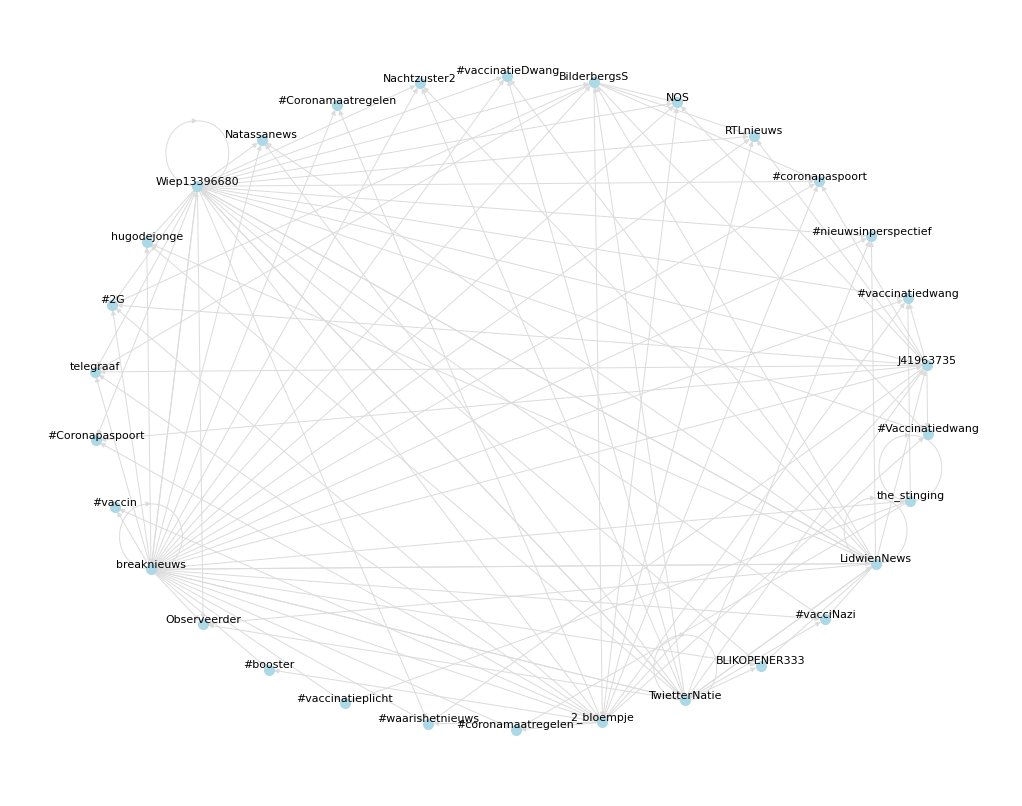

In [39]:
# This cell will create a visual representation of the network using the nodes with the top 30 eigenvector centrality values

# Get eigenvector centrality values
eigenvector_dict = nx.eigenvector_centrality(G)
eigenvector_df = pd.DataFrame.from_dict(eigenvector_dict, orient='index')

# Get top 30
node_selection = eigenvector_df.sort_values(by=0, ascending=False).head(30).index.to_list()

# Create and draw graph with a shell lay-out
H = G.subgraph(node_selection)
plt.figure(figsize=(14,11))
pos = nx.shell_layout(H, rotate=2)
nx.draw(
    H,
    pos=pos,
    with_labels=True,
    node_size=100,
    node_color="lightblue",
    edge_color="gainsboro",
    verticalalignment='bottom',
    font_size=11,
    
)

# Save graph as png file
plt.savefig('network_drawing')

In [40]:
# This cell gives the number of tweets, the number of nodes and number of edges per day

# Get all dates in the data
df_enriched['create_date'] = df_enriched['created_at'].dt.date
all_dates = list(set(df_enriched['create_date'].to_list()))
all_dates.sort()

# Create dataframe in which the data will be stored
df_overtime = pd.DataFrame(columns=['Date', 'Tweets','Nodes', 'Edges'])

# For each day
for date in all_dates:

  # Get all tweets posted on that day
    df_day_selection = df_enriched[df_enriched['create_date'] == date]

  # Create network graph for that day
    Gi = nx.DiGraph()
    for index, row in df_day_selection.iterrows():
        tweeter = row['Tweeter']
    for i in row['Mentions']:
        Gi.add_edge(tweeter, i)
    for j in row['Hashtags']:
        Gi.add_edge(tweeter, '#'+j)

  # Add the date, number of tweets, number of nodes and the number of edges for the specific day to the dataframe
    data = {'Date':date, 'Tweets':len(df_day_selection), 'Nodes': Gi.number_of_nodes(), 'Edges':Gi.number_of_edges()}
    df_overtime = df_overtime.append(data, ignore_index=True)

df_overtime = df_overtime.set_index('Date')
df_overtime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Tweets,Nodes,Edges
Date,,,
2021-12-13,492,646,2410
2021-12-14,548,773,2435
2021-12-15,620,838,2723
2021-12-16,385,616,2044
2021-12-17,495,694,2482
2021-12-18,417,580,2411
2021-12-19,507,582,2699
2021-12-20,743,764,3623
2021-12-21,970,1067,4247


In [85]:
import plotly.express as px
import plotly.graph_objects as go

In [86]:
# Create a line plot displaying the number of tweets for each day over time
fig = go.Figure(layout_yaxis_range=[0,1000])
fig.add_trace(go.Scatter(x=df_overtime.index, y=df_overtime['Tweets'], mode='lines', name='Tweets'))
fig.update_layout(title='The amount of Tweets over time',
                   xaxis_title='Date',
                   yaxis_title='Number of Tweets')
fig.show()

In [87]:
# Create a line plot displaying the number of nodes and the number of edges for each day over time
fig = go.Figure(layout_yaxis_range=[0,4500])
fig.add_trace(go.Scatter(x=df_overtime.index, y=df_overtime['Edges'], mode='lines', name='Edges'))
fig.add_trace(go.Scatter(x=df_overtime.index, y=df_overtime['Nodes'], mode='lines', name='Nodes'))
fig.update_layout(title='The amount of Nodes and Edges over time',
                   xaxis_title='Date',
                   yaxis_title='Number of Nodes / Edges')
fig.show()

This section of code was not used for the report due to page limitations but provides a start for further research

In [41]:
# The results of this piece of code was not used in the report due to page limitations but is interesting nonetheless
# This code calculates the four centrality measures (in-degree, out-degree, betweenness and eigenvector centrality) for each day individually
# The centrality measures per day can be used to analyse the centrality of nodes in the network over time how the network changes over time in more detail
df_enriched['create_date'] = df_enriched['created_at'].dt.date
all_dates = list(set(df_enriched['create_date'].to_list()))
all_dates.sort()
for date in all_dates:
    print('Date:', date)
    df_day_selection = df_enriched[df_enriched['create_date'] == date]

    print('# of tweets:', len(df_day_selection))

    Gi = nx.DiGraph()
    for index, row in df_day_selection.iterrows():
        tweeter = row['Tweeter']
    for i in row['Mentions']:
        Gi.add_edge(tweeter, i)
    for j in row['Hashtags']:
        Gi.add_edge(tweeter, '#'+j)

    print('# of nodes:', Gi.number_of_nodes(), '# of edges:', Gi.number_of_edges())
    print()

    print('indegree')
    indegree_dict = nx.in_degree_centrality(Gi)
    indegree_df = pd.DataFrame.from_dict(indegree_dict, orient='index')
    print(indegree_df.sort_values(by=0, ascending=False).head(15))
    print()

    print('outdegree')
    outdegree_dict = nx.out_degree_centrality(Gi)
    outdegree_df = pd.DataFrame.from_dict(outdegree_dict, orient='index')
    print(outdegree_df.sort_values(by=0, ascending=False).head(15))
    print()

    print('betweenness')
    betweenness_dict = nx.betweenness_centrality(Gi)
    betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index')
    print(betweenness_df.sort_values(by=0, ascending=False).head(15))
    print()

    print('eigenvector')
    eigenvector_dict = nx.eigenvector_centrality_numpy(Gi)
    eigenvector_df = pd.DataFrame.from_dict(eigenvector_dict, orient='index')
    print(eigenvector_df.sort_values(by=0, ascending=False).head(15))
    print()


    print('----------')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Date: 2021-12-13
# of tweets: 492
# of nodes: 646 # of edges: 2410

indegree
                                        0
#vaccinatiedwang                 0.579845
the_stinging                     0.167442
#Myocarditis                     0.167442
#coronamaatregelen               0.147287
#VaccinatieSchade                0.145736
#coronapaspoort                  0.144186
#2G                              0.142636
2_bloempje                       0.137984
#StopVaccination                 0.130233
#gentherapie                     0.130233
#jewordtbedonderdwaarjebijstaat  0.130233
leugenszijnsnel                  0.128682
hommel_b                         0.100775
trouw                            0.077519
#Omikron                         0.072868

outdegree
                        0
4Tchat           0.074419
Roseforyou007    0.031008
66EvM            0.027907
c3_cc3           0.026357
IngridTuinstra1  0.023256
brittenpat       0.023256
KarenVrie        0.021705
Batja83318732    0.021705
John11